# Prediction of the number of migrations between two districts per year Ridge (L2)

In [1]:
import math
import lxml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/pop_dyn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def normalize_features(feature_vector, columns_to_scale):
    for feature in columns_to_scale:
        scaler = StandardScaler()#with_mean=0, with_std=1)
        feature_vector[feature] = scaler.fit_transform(feature_vector[feature])
    return feature_vector

def split_train_test_by_quartiles(feature_vector, feature_columns, target_column, n_splits_dist, labels, train_size):
    X = feature_vector.loc[:, (feature_columns)]
    y = feature_vector.loc[:, target_column]
    
    # extract quartiles from continuous target to equally split between train/test
    label_list = pd.qcut(feature_vector[target_column], n_splits_dist, labels=labels).tolist()
    
    # Split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=32, 
                                                                  stratify=label_list)
    return X_train, X_test, y_train, y_test

In [3]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

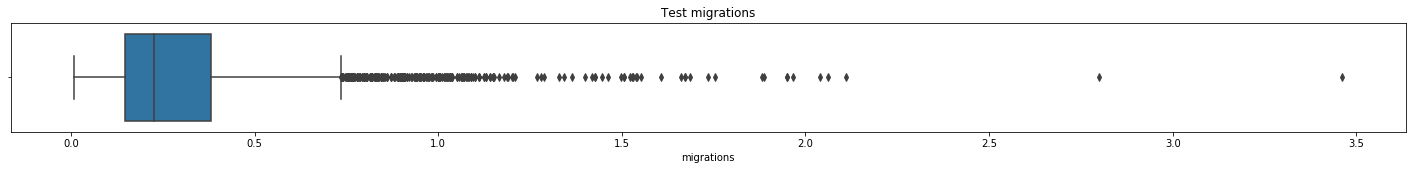

In [4]:
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(f_vector['migrations'])

In [5]:
f_vector[f_vector['migrations'] > 2.5]

,migrations,destination,origin,year,n_inhabitants_or,net_income_or,euribor,density_or,rev_1000_inh_or,var_review_or,...,rev_1000_inh_diff,var_review_diff,unemployed_diff,eldery_perc_diff,d_inner_n_diff,d_outer_n_diff,var_sale_m2_diff,var_rent_m2_diff,n_tran_rs_diff,n_tran_new_rs_diff
316,3.461478,Villa de Vallecas,Puente de Vallecas,2007,461817.0,23405.03,4.064,152.05,0.0,0.0,...,0.0,0.0,-0.076640,-5.222267,3.178951,-0.369562,0.113030,1.609018,16.677943,16.677943
1076,2.799199,Villa de Vallecas,Puente de Vallecas,2009,469133.0,23405.03,2.622,152.05,0.0,0.0,...,0.0,0.0,-0.111384,-5.991983,3.770764,-0.435502,5.080003,2.850579,18.237017,18.237017


In [6]:
# Remove the two outliers with values higher than 50
f_vector = f_vector[f_vector['migrations'] < 2.5] 

In [7]:
f_vector.shape

(3798, 45)

In [8]:
f_vector.loc[f_vector[f_vector['year'] <= 2008].index, 'period'] = 0
f_vector.loc[f_vector[(f_vector['year'] > 2008) & (f_vector['year'] <= 2011)].index, 'period'] = 2
f_vector.loc[f_vector[f_vector['year'] > 2011].index, 'period'] = 1

In [9]:
feature_columns = ['euribor','net_income_or', 'density_or', 'rev_1000_inh_or', 'unemployed_or', 'eldery_perc_or', 
                   'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_new_rs_or', 'var_review_or',
                   'n_tran_new_rs_or', "mortage_executions", 'var_n_biz' ,
                   'net_income_de', 'rev_1000_inh_de', 'var_review_de', 'unemployed_de','eldery_perc_de', 
                   "var_sale_m2_de", "var_rent_m2_de", "n_tran_new_rs_de", "density_de",'period']
target_column = "migrations"
n_splits_dist = 5
labels = ["q1","q2","q3","q4","q5"]
train_size = 0.9
alpha = 1.0

### Build train/test data sets

In [10]:
#feature_vector = normalize_features(f_vector, feature_columns)
#feature_vector['period'] = feature_vector['period'].astype(int)

In [11]:
#feature_vector[feature_vector['period']==1].head()

In [12]:
#f_vector.period.unique()

In [13]:
# Scale features
feature_vector = normalize_features(f_vector, feature_columns)
feature_vector['period'] = feature_vector['period'].astype(int)
feature_vector.loc[feature_vector[feature_vector['period']==1].index, 'period'] = 2
feature_vector.loc[feature_vector[feature_vector['period']==0].index, 'period'] = 1
feature_vector.loc[feature_vector[feature_vector['period']==-1].index, 'period'] = 0

# Split data set: train/test X/Y
info_cols = ["origin","destination","migrations"]
info = feature_vector.loc[:,(info_cols)]

feature_columns_ = [x for x in feature_columns if x not in ['period', 'year']]

X_train, X_test, y_train, y_test = split_train_test_by_quartiles(feature_vector, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [14]:
X_train.shape

(3418, 22)

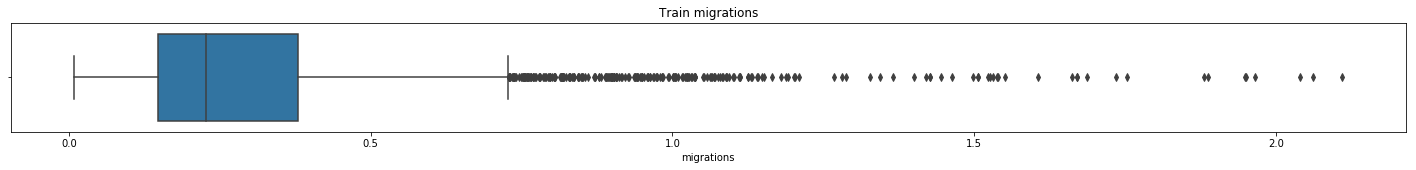

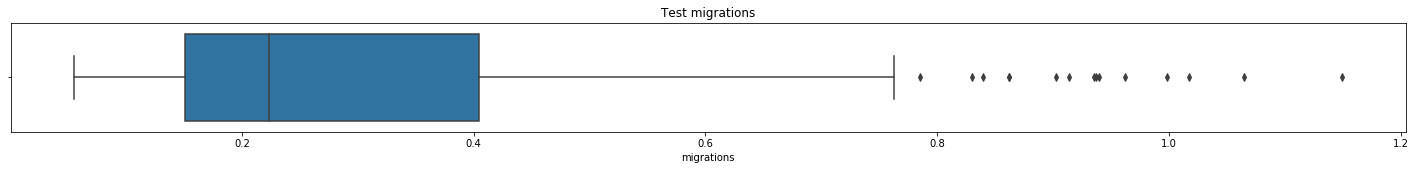

In [15]:
# Check if both samples have a similar distribution
_=plt.figure(figsize=(25, 2))
_=plt.title("Train migrations")
_=sns.boxplot(y_train)
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(y_test)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [17]:
# Train linear regression and predict migrations
reg = linear_model.Ridge(alpha = alpha)
reg = reg.fit(X_train.as_matrix(), y_train)
y_pred = reg.predict(X_test.as_matrix())
summary = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg.coef_})
print(f"r2 score: {reg.score(X_test.as_matrix(), y_test)}")

r2 score: 0.09313487001244247


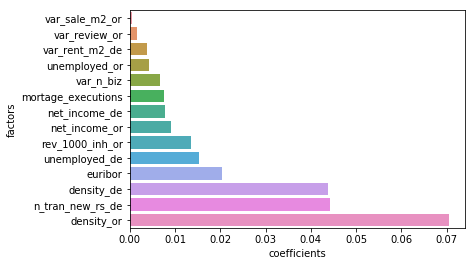

In [18]:
summary = summary.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary[summary['coefficients']>0])
significant_factors = summary[summary['coefficients']>0]

### Evaluate performance of the model

In [19]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 0.20
 The r2 score in the test data set is: 0.09


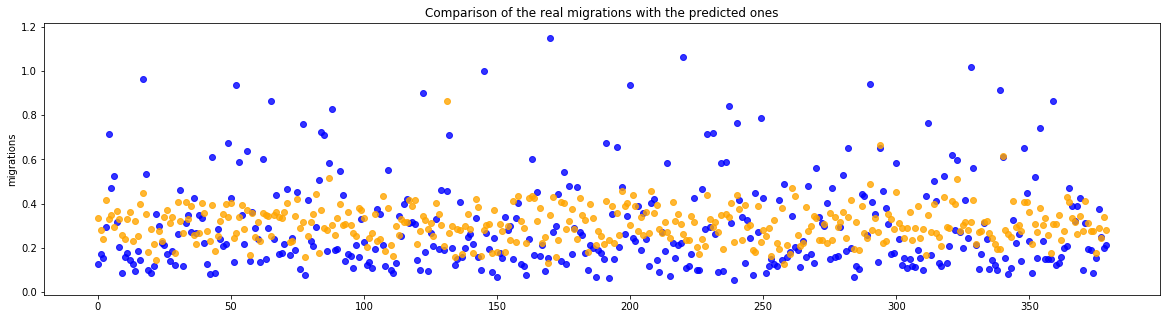

In [20]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

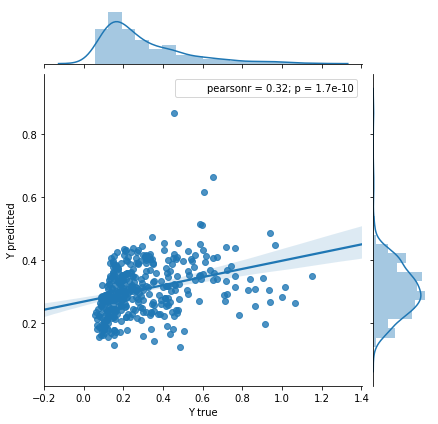

In [21]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Compare factors correlation with the internal migrations per period (pre, during, after crisis)

### Linear model until the economical crisis 2008

In [22]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_b = feature_vector[feature_vector['period']==0]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'year', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_b = feature_vector_b.loc[:,(info_cols)]

X_train_b, X_test_b, y_train_b, y_test_b = split_train_test_by_quartiles(feature_vector_b, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [23]:
# Train linear regression and predict migrations
reg_b = linear_model.Ridge(alpha = alpha)
reg_b = reg_b.fit(X_train_b.as_matrix(), y_train_b)
y_pred_b = reg_b.predict(X_test_b.as_matrix())
summary_b = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_b.coef_})
print(f"r2 score: {reg_b.score(X_test_b.as_matrix(), y_test_b)}")

r2 score: 0.14262751609314528


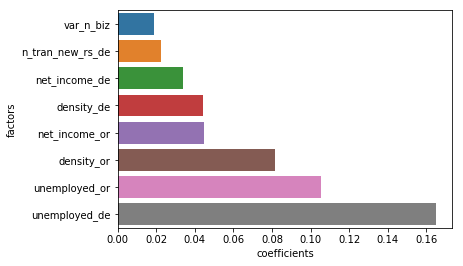

In [24]:
summary_b = summary_b.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_b[summary_b['coefficients']>0])
significant_factors_b = summary_b[summary_b['coefficients']>0]

In [25]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_b, y_pred_b))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_b, y_pred_b)))

The RMSE in the test data set is: 0.30
 The r2 score in the test data set is: 0.14


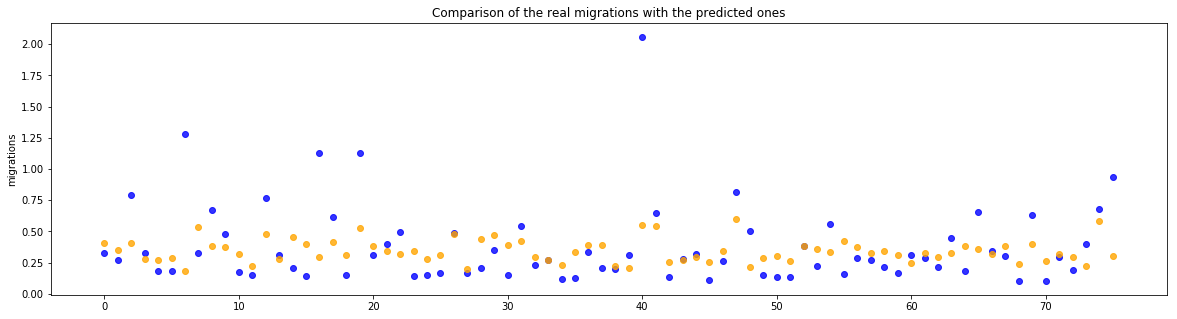

In [26]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_b)), y=y_test_b, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_b)), y=y_pred_b, fit_reg=False, color="orange")

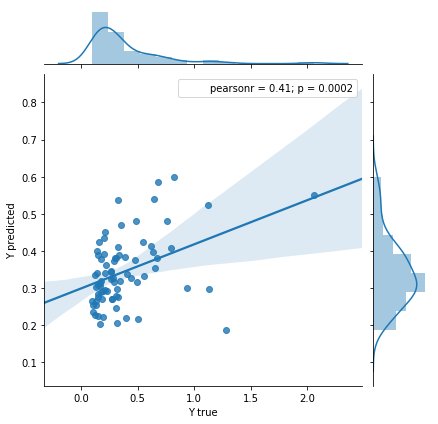

In [27]:
_=sns.jointplot(x=y_test_b, y=y_pred_b, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

### Linear model during the crisis 2009-2011

In [28]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_d = feature_vector[feature_vector['period']==2]
feature_columns_ = [x for x in feature_columns if x not in ['period','year','rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_d = feature_vector_d.loc[:,(info_cols)]

X_train_d, X_test_d, y_train_d, y_test_d = split_train_test_by_quartiles(feature_vector_d, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [29]:
# Train linear regression and predict migrations
reg_d = linear_model.Ridge(alpha = alpha)
reg_d = reg_d.fit(X_train_d.as_matrix(), y_train_d)
y_pred_d = reg_d.predict(X_test_d.as_matrix())
summary_d = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_d.coef_})
print(f"r2 score: {reg_d.score(X_test_d.as_matrix(), y_test_d)}")

r2 score: 0.14847309323205637


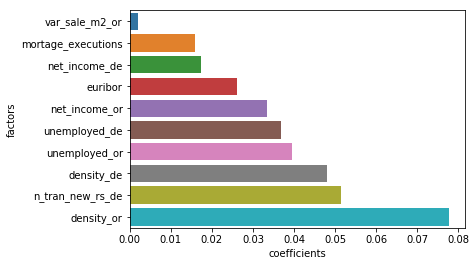

In [30]:
summary_d = summary_d.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_d[summary_d['coefficients']>0])
significant_factors_d = summary_d[summary_d['coefficients']>0]

In [31]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_d, y_pred_d))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_d, y_pred_d)))

The RMSE in the test data set is: 0.29
 The r2 score in the test data set is: 0.15


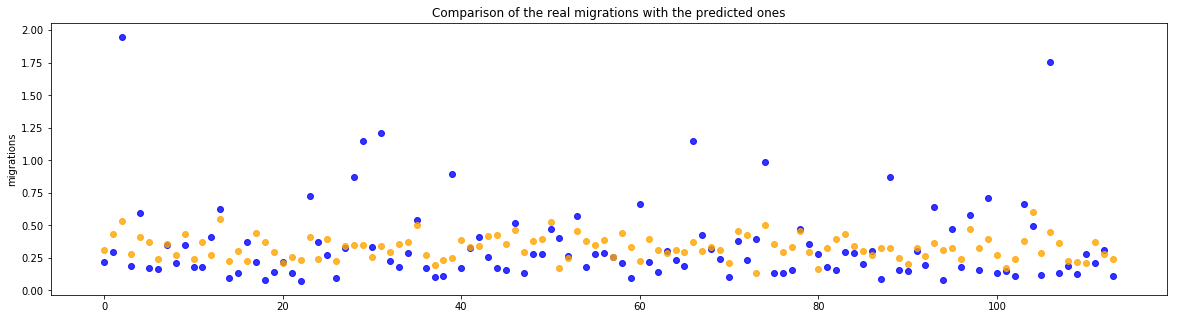

In [32]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_d)), y=y_test_d, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_d)), y=y_pred_d, fit_reg=False, color="orange")

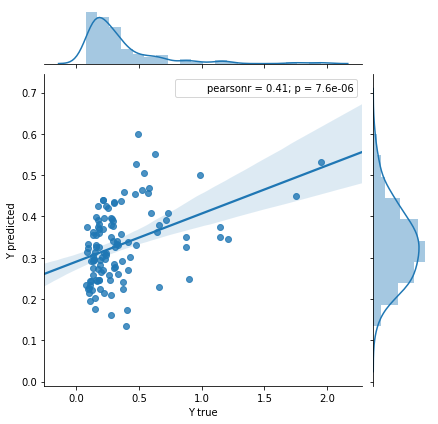

In [33]:
_=sns.jointplot(x=y_test_d, y=y_pred_d, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

### Linear model after the european crisis of 2011

In [34]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_a = feature_vector[feature_vector['period']==1]
feature_columns_ = [x for x in feature_columns if x not in ['period','year']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_a = feature_vector_a.loc[:,(info_cols)]

X_train_a, X_test_a, y_train_a, y_test_a = split_train_test_by_quartiles(feature_vector_a, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [35]:
# Train linear regression and predict migrations
reg_a = linear_model.Ridge(alpha = alpha)
reg_a = reg_a.fit(X_train_a.as_matrix(), y_train_a)
y_pred_a = reg_a.predict(X_test_a.as_matrix())
summary_a = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_a.coef_})
print(f"r2 score: {reg_a.score(X_test_a.as_matrix(), y_test_a)}")

r2 score: 0.0654018022431394


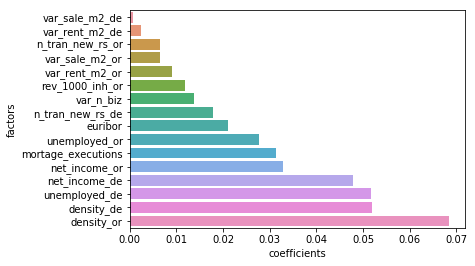

In [36]:
summary_a = summary_a.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_a[summary_a['coefficients']>0])
significant_factors_a = summary_a[summary_a['coefficients']>0]

In [37]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_a, y_pred_a))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_a, y_pred_a)))

The RMSE in the test data set is: 0.22
 The r2 score in the test data set is: 0.07


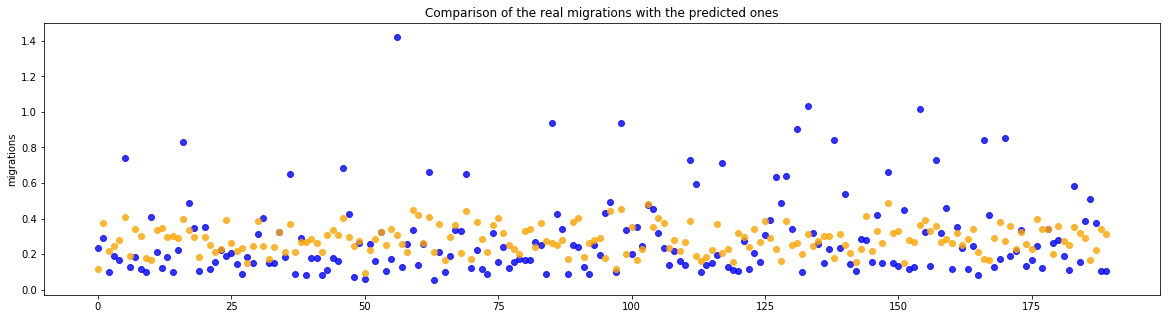

In [38]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_a)), y=y_test_a, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_a)), y=y_pred_a, fit_reg=False, color="orange")

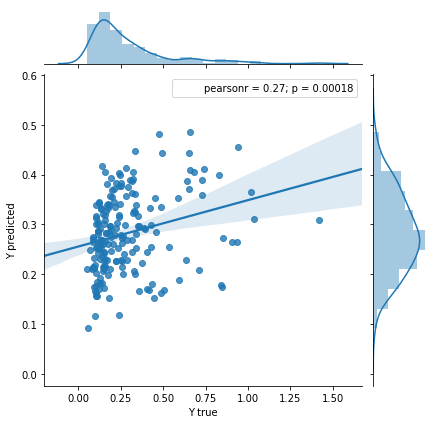

In [39]:
_=sns.jointplot(x=y_test_a, y=y_pred_a, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Comparison of factors overall and per period

In [40]:
set(significant_factors.factors.tolist() + significant_factors_a.factors.tolist() + \
              significant_factors_d.factors.tolist() + significant_factors_b.factors.tolist())

{'density_de',
 'density_or',
 'euribor',
 'mortage_executions',
 'n_tran_new_rs_de',
 'n_tran_new_rs_or',
 'net_income_de',
 'net_income_or',
 'rev_1000_inh_or',
 'unemployed_de',
 'unemployed_or',
 'var_n_biz',
 'var_rent_m2_de',
 'var_rent_m2_or',
 'var_review_or',
 'var_sale_m2_de',
 'var_sale_m2_or'}

In [41]:
# Define unique existing factors and output structure
factors = set(significant_factors.factors.tolist() + significant_factors_a.factors.tolist() + \
              significant_factors_d.factors.tolist() + significant_factors_b.factors.tolist())

factors_ = ['density_de', 'density_or', 'net_income_or','net_income_de', 'unemployed_de', 'unemployed_or', 
            'rev_1000_inh_or', 'var_review_or', 'n_tran_new_rs_de', 'n_tran_new_rs_or','var_rent_m2_or',
            'var_rent_m2_de', 'var_sale_m2_de', 'var_sale_m2_or', 'euribor','var_n_biz', 'mortage_executions']

# Assign coeficient values to each period
period_names = ['whole period', 'before_crisis', "between_crisis", "after_crisis"]
periods = [significant_factors, significant_factors_b, significant_factors_d, significant_factors_a]
results = []
for period in range(len(periods)):
    df = periods[period].loc[:,('factors','coefficients')]
    df['period'] = period_names[period]
    results.append(df)
significant_facts = pd.concat(results)
significant_facts["factors"] = significant_facts["factors"].astype("category", categories=factors_, ordered=True)
significant_facts = significant_facts.dropna()

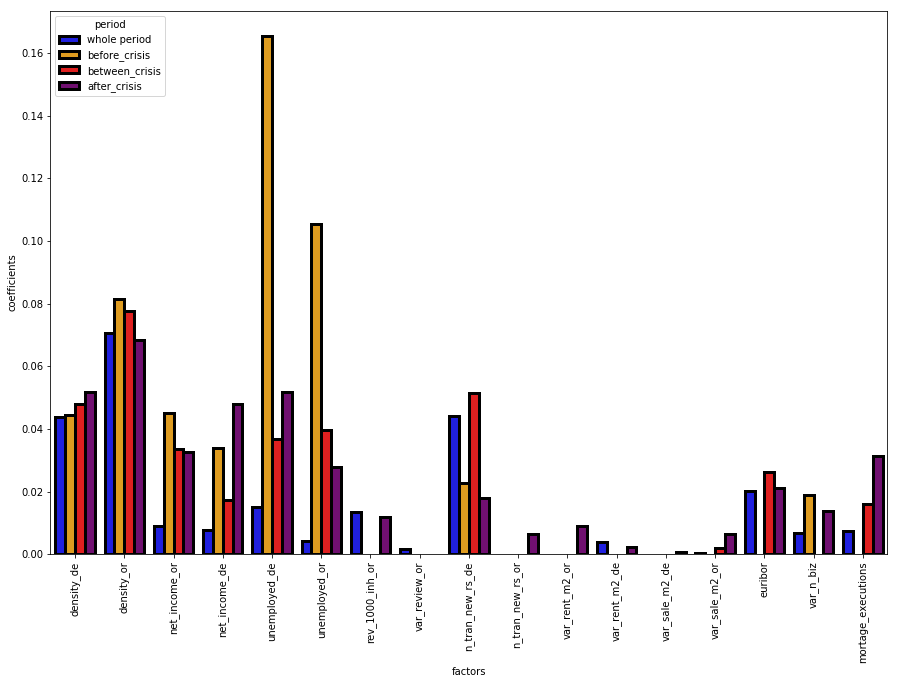

In [42]:
_=plt.figure(figsize=(15, 10))
_=sns.barplot(x='factors',y='coefficients',data=significant_facts, hue='period', palette=['blue','orange','red','purple'],
              linewidth=3, edgecolor='black')
_=plt.xticks(rotation=90)

Text(0.5,1,'2007-2017')

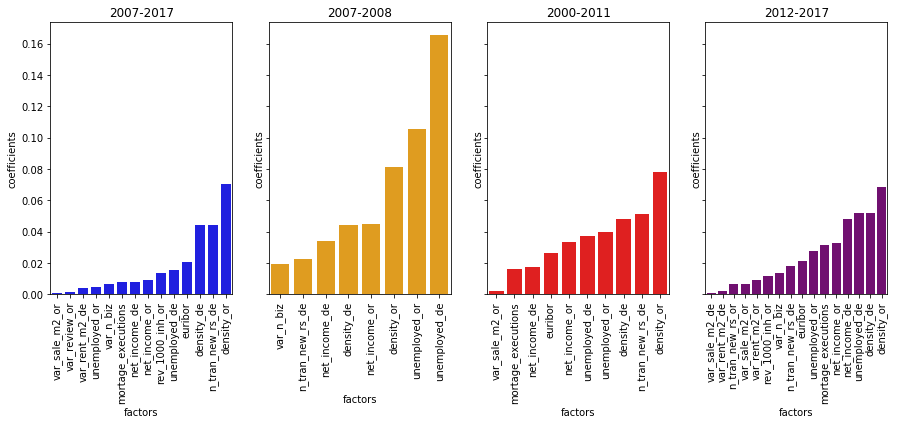

In [43]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15,5))
sns.barplot(x='factors',y='coefficients',data=significant_factors_b,color='orange',label='before crisis', ax=ax2)
sns.barplot(x='factors',y='coefficients',data=significant_factors_d,color='red',label='during crisis', ax=ax3)
sns.barplot(x='factors',y='coefficients',data=significant_factors_a,color='purple',label='after crisis', ax=ax4)
sns.barplot(x='factors',y='coefficients',data=significant_factors,color='blue',label='after crisis', ax=ax1)
for i,ax in enumerate(f.axes):
    plt.sca(ax)
    plt.xticks(rotation=90)
ax2.set_title("2007-2008")
ax3.set_title("2000-2011")
ax4.set_title("2012-2017")
ax1.set_title("2007-2017")